# <center><ins>Extended Test:</ins></center>
 # <center><ins> K-Nearest Neighbours (KNN) & Support Vector Machine (SVM)</ins></center>

## <ins>Part 1: Set-Up</ins>

 First of all, we import all the random packages and set a random seed to ensure the code is reproducible. 

In [2]:
# Import all necessary packages
import os,sys,inspect
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from math import floor, ceil
from numpy import mean, std
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from dfmapper import DataFrameMapper
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from category_encoders import TargetEncoder
import category_encoders as ce
import dateutil.parser
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
import plotly.express as px
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

# Set random seed
np.random.seed(3123)

The next task is to load our data. This includes: the 'mimic_train.csv' file with the train set -covariates and target variable included; the 'mimic_test_death.csv' file that provides the test set covariates; finally, we load the file 'mimic_diagnoses.csv' that includes the metadata. After the load, we represent the imported data in data frames.

In [3]:
# Load Data and represent csv as dataframe
data = pd.read_csv("/Users/Ramon/Documents/Estudio/BSE/Term_1/Computational_Machine_Learning/Tests/Test_2/mimic_train.csv")
data = pd.DataFrame(data)
data.nunique()

X_test0 = pd.read_csv("//Users/Ramon/Documents/Estudio/BSE/Term_1/Computational_Machine_Learning/Tests/Test_2/mimic_test_death.csv")
X_test0 = pd.DataFrame(X_test0)

X_metadata = pd.read_csv("//Users/Ramon/Documents/Estudio/BSE/Term_1/Computational_Machine_Learning/Tests/Test_2/MIMIC_diagnoses.csv")

A brief exploration of our datasets is performed to gain a preliminary intuition of our variables. 

In [173]:
#Exploring Data Sets
print(data.shape)
print(X_test0.shape)
print(data.columns)
print(data["HOSPITAL_EXPIRE_FLAG"].value_counts())

(20885, 41)
(5221, 39)
Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'LOS'],
      dtype='object')
0    18540
1     2345
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64


## <ins>Part 2: Pre-Processing</ins>

### A) Analyzing outliers

First of all, we contemplate the possibility of excluding outliers that are beyond 3 standard deviations from the mean. We only analyze some numerical variables in the training set for potencial outlier exclusion. 

In [174]:
# Define a function to remove outliers from a particular dataframe column
def subset_by_iqr(df, column, whisker_width):
    """Remove outliers from a dataframe by column, including optional
       whiskers, removing rows for which the column value are
       less than Q1-1.5IQR or greater than Q3+1.5IQR.
    Args:
        df (`:obj:pd.DataFrame`): A pandas dataframe to subset
        column (str): Name of the column to calculate the subset from.
        whisker_width (float): Optional, loosen the IQR filter by a
                               factor of `whisker_width` * IQR.
    Returns:
        (`:obj:pd.DataFrame`): Filtered dataframe
    """
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]


# Exclude outliers that are beyond 3 std from the mean for some numerical variables in training set
data_outliers = subset_by_iqr(data, column='HeartRate_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='HeartRate_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='SysBP_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='SysBP_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='DiasBP_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='DiasBP_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='MeanBP_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='MeanBP_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='RespRate_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='RespRate_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='TempC_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='TempC_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='SpO2_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='SpO2_Max', whisker_width=3)

data_outliers = subset_by_iqr(data_outliers, column='Glucose_Min', whisker_width=3)
data_outliers = subset_by_iqr(data_outliers, column='Glucose_Max', whisker_width=3)

The impact on performance metrics provoked by the exclusion of outliers was assesed for different values of the whisker width. As outlier exclusion didn't have a significant impact on subsequent used performance metrics -it even worsen simulated predictions assesed by cross-validation- we opted to keep rare extreme values in our training set. This may seem sensible as extreme values in one variable may provide some valuable information regarding the probability of survival. In short, the evidence suggested it was convenient to keep outliers in our training set. 

### B) Working with Metadata

The metadata provided information on the name of co-morbilities (ICD9_CODE) associated to a main diagnose for a subset of patients in the training set. Naturally, the type of co-morbility possibly adds explanatory power to our model attempting to predict the probability of survival. Our first step is to merge our metadata data frame with our target variable present in the training set. After this we target encoded the name of the co-morbilities: recall target encoding involves replacing the “features with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data". In simple terms, we replace the categories considering the effect they might have on the target variable. After targeting encoding ICD9_CODE we computed the mean value of ICD9_CODE for each subject_id as a representative measure. Finally, we merged the encoded feature with our training set hence adding an aditional covariate. Note that unlike one hot encoding (extension), target encoding does not substantially increase dimensionality.   

In [175]:
# Target encode variable ICD9_CODE from metadata

## Rename metadata columns to ensure compatibility with training set
X_metadata = X_metadata.rename(columns={'SUBJECT_ID':'subject_id'})
X_metadata = X_metadata.rename(columns={'HADM_ID':'hadm_id'})

# Merge the relevant columns from training set with metadata using subject_id as our main key
cols_y = data[['subject_id','HOSPITAL_EXPIRE_FLAG']]
X_metadataA = X_metadata.merge(cols_y,how='inner',on='subject_id')

# Choose encoder, fit and transform our mutated metadata dataframe
encoder = TargetEncoder()
encoded_ICD9 = encoder.fit_transform(X_metadataA[['ICD9_CODE']],X_metadataA[['HOSPITAL_EXPIRE_FLAG']])

# Concatenate our mutated metadata dataframe with encoded feature 
X_metadataB = pd.concat([X_metadataA,encoded_ICD9],axis=1)

# Group mutated metadata frame with encoded feature by subject_id and hadm_id, 
# and calculate mean of the target encoded variable to add as a new feature in training set
X_metadataC = X_metadataB.groupby(['subject_id','hadm_id'],as_index=False)['ICD9_CODE'].mean()

# Add target encoded variable ICD9_CODE to training set
data0 = data.merge(X_metadataC,how='left',on=['subject_id','hadm_id'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


The analogous process as the preceeding one was performed for the test set. Nonetheless, instead of using the test set to fit and transform our encoder we use the training set data to impute variable ICD9_CODE in our test set. 

In [176]:
# Select subject_id column in test set and merge feature with metadata dataframe using subject_id as main key
cols_y_T = X_test0[['subject_id']]
X_metadata1 = X_metadata.merge(cols_y_T,how='inner',on='subject_id')

# Choose encoder, fit it in the training set and transform the test set 
encoder = TargetEncoder()
encoded_ICD9 = encoder.fit(X_metadataA[['ICD9_CODE']],X_metadataA[['HOSPITAL_EXPIRE_FLAG']])
encoded_ICD9_T = encoder.transform(X_metadata1[['ICD9_CODE']])

# Concatenate our metadata for test set with target encoded feature ICD9_CODE
X_metadata2 = pd.concat([X_metadata1,encoded_ICD9_T],axis=1)

# Select the relevant columns from metadata: subject_id, hadm_id and ICD9_CODE
X_metadata3 = X_metadata2.iloc[:,[0,1,4]]

# Group mutated metadata frame with encoded feature by subject_id and hadm_id, 
# and calculate mean of the target encoded variable to add as a new feature in test set
X_metadata4 = X_metadata3.groupby(['subject_id','hadm_id'],as_index=False)['ICD9_CODE'].mean()

# Add target encoded variable ICD9_CODE to test set
X_testA = X_test0.merge(X_metadata4,how='left',on=['subject_id','hadm_id'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


Another potentially useful information implicitely present in the metadata is the number of co-morbilities. We would like to include this feature as an explanatory variable both on the training set and test set.  

In [177]:
# Make sure our metadata column names have been renamed appropiately for compatibility with training set
X_metadata = X_metadata.rename(columns={'SUBJECT_ID':'subject_id'})
X_metadata = X_metadata.rename(columns={'HADM_ID':'hadm_id'})

# Group our metadata by subject_id and hadm_id and count the number of comorbilities indicated by the column SEQ_NUM
X_metadata2 = X_metadata.groupby(['subject_id','hadm_id'],as_index=False)['SEQ_NUM'].count()

# Merge our newly created variable with training set using subject_id and hadm_id as keys
data1 = data0.merge(X_metadata2,how='left',on=['subject_id','hadm_id'])

Analogously, we add the newly created explanatory variable to the corresponding patients in the test set, using -as in the trainig set merge- subject_id and hadm_id as keys. 

In [178]:
# Merge test set with metadata to conform the new test set using subject_id and hadm_id as keys
X_testB = X_testA.merge(X_metadata2,how='left',on=['subject_id','hadm_id'])

### C) Creating Age variable

Despite the age of each patient is not explicitely present in the dataset, it may be infered. We have the admision time and the date of birth of almost every patient. Therefore, by performing a simple subtraction we can obtain the estimated age of most of the patients. 

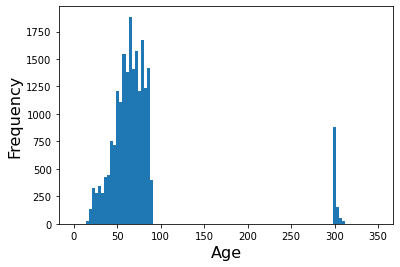

In [179]:
# Select appropiate columns from the training set to find date difference
data_age = data1[['DOB', 'ADMITTIME']]

# We convert the relevant columns to standard date time represent them in a dataframe 
data_age_dob= pd.to_datetime(data_age['DOB'])
data_age_adm= pd.to_datetime(data_age['ADMITTIME'])
data_age_dob = pd.DataFrame(data_age_dob)
data_age_adm = pd.DataFrame(data_age_adm)

# Extract the year of each of the relevant columns
data_age_dob['Age'] = pd.DatetimeIndex(data_age_dob.iloc[:,0]).year
data_age_adm['Age'] = pd.DatetimeIndex(data_age_adm.iloc[:,0]).year

# Perform the subtraction to find the age and load it into a dataframe
data_diff = data_age_adm['Age']-data_age_dob['Age']
data_diff=pd.DataFrame(data_diff )

# Represent the Age in a histogram
plt.xlabel("Age", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.hist(data_diff,bins=100,range=[0, 350],label='AGE')
plt.show()

As we can witness from the histogram, there are some values above 300 that are not plausible. After some online investigation we discovered that "age for patients older than eighty-nine is masked as 300 in MIMIC- III for privacy reasons". Therefore, we firstly found the difference between the implausible ages and 89 and secondly subtracted to each implausible value the obtained difference in the preceeding step. The result is a sensible histogram for age distribution. 

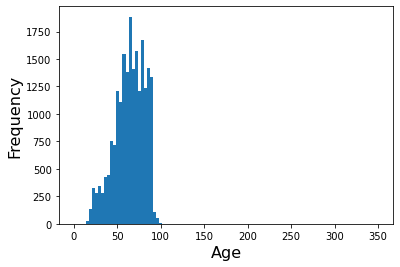

In [180]:
# Filter for ages below 100 and obtain the maximum value to certify its 89
below_100 = data_diff[data_diff['Age']<100]
below_100.max()

# Filter for ages above 100 and obtain the min which should be 300 (histogram)
above_100 = data_diff[data_diff['Age']>100]
above_100.min()

# Subtract to each age above 100 the difference between 300 and 89 
data_diff['Age'] = np.where(data_diff['Age'] >100 , data_diff['Age'] - (300-89), data_diff['Age'])

# plot histogram with appropiate labels to certify a sensible age distribution was obtained
plt.xlabel("Age", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.hist(data_diff,bins=100,range=[0, 350])
plt.show()

# Merge the new age column in our training set
data2= pd.concat([data1,data_diff],axis=1)

The analogous procedure was performed in the test set to obtain the corresponding age of each patient. 

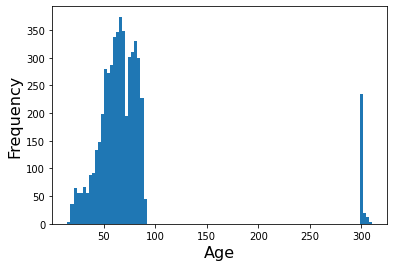

In [181]:
# Select appropiate columns from the test set to find date difference
data_age1 = X_testB[['DOB', 'ADMITTIME']]

# We convert the relevant columns to standard date time and represent them in a dataframe 
data_age_dob1= pd.to_datetime(data_age1['DOB'])
data_age_adm1= pd.to_datetime(data_age1['ADMITTIME'])
data_age_dob1 = pd.DataFrame(data_age_dob1)
data_age_adm1 = pd.DataFrame(data_age_adm1)

# Extract the year of each of the relevant columns
data_age_dob1['Age'] = pd.DatetimeIndex(data_age_dob1.iloc[:,0]).year
data_age_adm1['Age'] = pd.DatetimeIndex(data_age_adm1.iloc[:,0]).year

# Perform the subtraction to find the age and load it into a dataframe
data_diff1 = data_age_adm1['Age']-data_age_dob1['Age']
data_diff1=pd.DataFrame(data_diff1)

# Represent the Age in a histogram
plt.xlabel("Age", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.hist(data_diff1,bins=100)
plt.show()

Given the same problem we had with age in the training set arises in the test set, we adopt the same strategy to deal with the inconsistencies. As we witness in the new histogram, the age distribution is now adequately represented. 

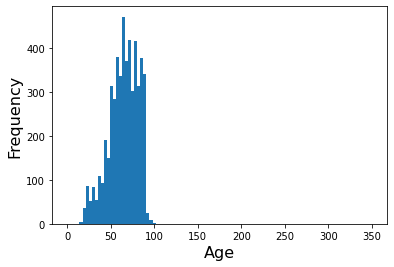

In [182]:
# Filter for ages below 100 and obtain the maximum value to certify its 89
below_100_ = data_diff1[data_diff1['Age']<100]
below_100_.max()

# Filter for ages above 100 and obtain the min which should be from histogram 300
above_100_ = data_diff1[data_diff1['Age']>100]
above_100_.min()

# Subtract to each age above 100 the difference between the minimum age above 100 and 89
data_diff1['Age'] = np.where(data_diff1['Age'] >100 , data_diff1['Age'] - (300-89), data_diff1['Age'])
data_diff1.max()

# Plot histogram with appropiate labels to certify a sensible age distribution was obtained
plt.xlabel("Age", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.hist(data_diff1,bins=100,range=[0, 350])
plt.show()

# Merge the new age column in our test set
X_testC= pd.concat([X_testB,data_diff1],axis=1)

### D) Train-Set Split

Furtermore, we explicitely separate our training set covariates, our training set target variable and our test set covariates. 

In [183]:
# Select explanatory variables from traing data
X_train = data2.drop(["HOSPITAL_EXPIRE_FLAG"],axis=1)

# Select target variable from traing data
y_train = data2[["HOSPITAL_EXPIRE_FLAG"]]

# Load test set covariates in a data frame
X_test = pd.DataFrame(X_testC)

Because not all of the variables in the training set are present in the test set, we drop those covariates that are not present in both.

In [184]:
#Drop variables in train set that are not in test set
col_not_to_drop = X_test.columns
X_train = X_train[col_not_to_drop]

A preliminary treatment of missing values involves dropping those columns that have 15% or more missing values as the information cost associated to imputing them may outweight their explicative power. 

In [185]:
# Check features that have a'lot of missing values
X_train.isna().sum()

# Percentage of null in every column
null_percentage = X_train.isnull().sum()/X_train.shape[0]*100

# Drop columns having more than 15% null
col_to_drop = null_percentage[null_percentage>15].keys()
X_train1 = X_train.drop(col_to_drop, axis=1)

# Update test set with columns dropped in training set
X_test1 = X_test.drop(col_to_drop,axis=1)

As no columns have more that 15% of missing values, the X training set wasn't affected. Concomitantly, no variables were dropped in the test set.

### E) Target encoding & scalarizing

In the following section we will proceed to target encode the categorical features and scalarize numerical ones. We will work with training set and test set simultaneously. Note the scalarization and target encoding of the test set will be done using only the training set data.

We first start by generating the following data frames: X train categorical, X train numerical, X test categorical and X test numerical. 

In [186]:
# Distinguish between data types of numerical columns (int,float) and categorical (object) on training set
numeric_columns=list(X_train1.select_dtypes(['int64','float64']).columns)
categorical_columns=list(X_train1.select_dtypes('object').columns)

# Filter separating categorical columns and numerical columns in training set
X_train_cat = X_train1.filter(categorical_columns, axis=1)
X_train_num = X_train1.filter(numeric_columns, axis=1)

# Distinguish between data types of numerical columns (int,float) and categorical (object) on test set
numeric_columns=list(X_test1.select_dtypes(['int64','float64']).columns)
categorical_columns=list(X_test1.select_dtypes('object').columns)

# Filter separating categorical columns and numerical columns in test set
X_test_cat = X_test1.filter(categorical_columns, axis=1)
X_test_num = X_test1.filter(numeric_columns, axis=1)

We now proceed to scalarize numerical columns of training set and test set (based on training set metrics).

In [187]:
# Define scaler
scaler = preprocessing.StandardScaler()

# Fit scaler to training set
scaler.fit(X_train_num)

# Transform test set and training set using preceeding scalerizer fitted in train set
X_train_num1 = scaler.transform(X_train_num)
X_test_num1 = scaler.transform(X_test_num)

# Convert the scalarized numerical columns of train/test set to data frame
X_train_num = pd.DataFrame(X_train_num1,columns=X_train_num.columns)
X_test_num = pd.DataFrame(X_test_num1,columns=X_test_num.columns)

Now we proceed to target encode categorical variables both in the train set and the test set. 

In [188]:
# Define target encoder
encoder = TargetEncoder()

# Fit and transform training set using target encoding
X_train_cat_enc = encoder.fit_transform(X_train_cat,y_train)

# Represent encoded categorical variables of training set in a data frame
X_train_cat_enc = pd.DataFrame(X_train_cat_enc)

# Target encode categorical variables in test set using train set data
X_test_cat_enc = encoder.transform(X_test_cat)

# Represent encoded categorical variables of test set in a data frame
X_test_cat_enc = pd.DataFrame(X_test_cat_enc)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


We finally combine back numerical and categorical columns on both training and test set.

In [189]:
# Concatenate scalarized numerical variables and encoded categorical variables in one data fram (train set)
X_train2 = pd.concat([X_train_num, X_train_cat_enc], axis=1)

# Concatenate scalarized numerical variables and encoded categorical variables in one data fram (test set)
X_test2 = pd.concat([X_test_num, X_test_cat_enc], axis=1)

### F) Imputing missing values

How to impute missing values is one of the most importante tasks in the pre processing of the data. We will use k nearest neighbors through KNNImputer in order to impute missing values of a patient. The strategy is to replace a missing value of a specific feature of a given patient A using the records of the set of patients that resemble the most patient A in other recorded features. In other words, imputing missing values by similarity. 
The natural question that comes up is how many neighbors or similar patients we should consider to fill our missing values. To determine this we assumed a potential standard Knn model (number of neighbors, weights and algorithm exogenous) and fed it with different possible values of number of neighbors. This procedure will suggest the optimal number of neighbors to use to impute our missing values. Cross validation is used to asses predictive capacity of the model for the different possible neighbors and criteria of optimality is provided by area under the curve (AUC) performance metric. 
The following pipeline serves this purpose:

In [ ]:
# Create an empty list to store results
results = list()

# Choose the potential nearest neighbor values 
strategies = [str(i) for i in [6,10,20,35,50]]
for s in strategies:
    # Create the modeling pipeline using standard Knn model 
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m',
               KNeighborsClassifier(weights='distance',algorithm='auto',metric='manhattan',n_neighbors=300))])
    # Evaluate the model's predictive capacity thprugh cross validation using roc_auc criteria
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
    scores = cross_val_score(pipeline, X_train2, y_train, scoring='roc_auc', cv=cv, n_jobs=-1,verbose=True)
    # Store results
    results.append(scores)
    print('>%s %.3f (%.3f)' % (s, np.mean(scores), np.std(scores)))

# Plot box plot 
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   37.9s remaining:   37.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   38.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


>6 0.932 (0.003)


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   33.6s remaining:   33.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   35.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


>10 0.931 (0.003)


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   49.7s remaining:   49.7s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   51.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


>20 0.930 (0.004)


Note the boxplot represents the accurracy for the different proposed number of neighbors. 6 neighbors is the optimal number of neighbors to include in our knn imputer. Now we can proceed to replace the missing values via KNNImputer in both our training set and test set. 

In [ ]:
# Define the Knn imputer with the number of neighbors to use
imputer = KNNImputer(n_neighbors=6)

# Fit and transform the training data using imputer
X_train3 = imputer.fit_transform(X_train2)

# Represent the imputed training data in a data frame
X_train3 = pd.DataFrame(X_train3,columns=X_train2.columns)

# Verify missing values were imputed appopiately
X_train3.isna().sum()

In [ ]:
# Define the Knn imputer with the number of neighbors to use
imputer = KNNImputer(n_neighbors=6)

# Fit test data using imputer
imputer.fit(X_train2)

# Transform the testdata using imputer
X_test3 = imputer.transform(X_test2)

# Represent the imputed test data in a data frame
X_test3 = pd.DataFrame(X_test3,columns=X_test2.columns)

# Verify missing values were imputed appopiately
X_test3.isna().sum()

### G) Variable Selection

The posterior step in our analysis is to select those variables that we anticipate have some incidence on the patients probability of survival and dropping the rest. Recall that adding variables that have no explanatory power whatsover generates noise that erodes the capacity of our model to capture the underlying pattern in the data.


We first find the correlation betweeen each feature and our target future to explore which variables might be relevant and undergo a process of variable selection. 

In [ ]:
# Concatenate X train set with y train set to investigate correlations
data3 = pd.concat([X_train3,y_train],axis=1)

# Compute the correlation matrix
corr = data3.corr()

# Represent it in a data frame and select column involving target variable
corr = pd.DataFrame(corr[['HOSPITAL_EXPIRE_FLAG']])
corr

Naturally, those columns that serve the purpose of identifying the patient (subject_id & hadm_id) will have no impact whatsoever in our target variable. We also drop date of birth (DOB) and admission time (ADMITTIME) that were already used to estimate the age and by themselves add no explanatory power. 

Additional features such as religion,gender and marital status and are candidates to be discarded as we suspect they are neutral with respect to the survival probability (some trials were performed with inclusion of theses variables and performance did not improve). Moreover, the particularly low correlation presents aditional evidence to support model exclusion. 
Furthermore, the mean of each of the medical categories (heart rate, sys, dias, etc) measured were dropped: not only they are composed of variables already present in the data (max and min) that precisely capture the presence of lower or upper deviations, but we conjecture that it is the presence of extreme values in a given category what impacts our target variable. In other words, the mean value of each medical category adds no relevant information. This is certified by our correlation column given the correlation of the mean value of a medical category is always below the correlation with either the minimum value or the maximimum value.  

In [ ]:
# Features from training set
X_train3.columns

# Drop suspected irrelevant columns
X_train4= X_train3.drop(['subject_id','hadm_id','icustay_id','DOB','ADMITTIME','RELIGION','Diff','HeartRate_Mean',
                         'SysBP_Mean','DiasBP_Mean','MeanBP_Mean','RespRate_Mean','TempC_Mean','SpO2_Mean',
                          'Glucose_Mean','GENDER','MARITAL_STATUS'],axis=1)
X_train4.columns

The variables kept we speculate most likely affect our target variable. Those include the minimum and maximum values of each medical category such as heart rate, Sys, Dias, MeanBP, respiratory rate and temperature. Otherfeatures such as admission type, medical insurance, diagnosis, taget encoded ICD9_CODE, the first careunit. the number of co-morbilities and the age most likely play a role in explaining the probability of survival. Ethnicity was included because after some trials the explanatory power marginally increased. 

The concomitant exclusion was performed in the X test set. 

In [ ]:
# Save icustay_id before dropping to merge identify patients once predictions are made
icustay_id=X_test3["icustay_id"]

# Drop irrelevant columns in the X test set
X_test4 = X_test3.drop(['subject_id','hadm_id','icustay_id','DOB','ADMITTIME','RELIGION','Diff','HeartRate_Mean',
                         'SysBP_Mean','DiasBP_Mean','MeanBP_Mean','RespRate_Mean','TempC_Mean','SpO2_Mean',
                          'Glucose_Mean','GENDER','MARITAL_STATUS'],axis=1)

## <ins>Part 3: Knn Model</ins>

The K Nearest Neighbors model is a supervised leraning classifier which uses proximity -computed by a measure of distance- to classify or predict a given data point. In a classification task, a given observation is labeled considering the relative proximity of the k nearest data point, where k is a hyperparameter to be tuned. 

 The hyperparameters are exogenous parameters that are not determined within the model. Even though we will undergo a tuning process to select most of them, we will already fix two of the hyperparameter when instatiating the model. 

First of all we instatiate our KNN model.

In [ ]:
#Instatiate KNN
MyKNN = KNeighborsClassifier(weights='distance',metric='minkowski')

The "weights" argument refers to the criteria used to assign a relative weight to the neighboring data points used to classify a particular observation. We prefer to use a distance metric over uniformly weighting all surrounding data points given we know from scratch that we want closer data points to have more weight than those that are further apart. Moreover, we will define the metric to measure distances to the minkowski one, given both the euclidean distance (p=2) and the manhattan distance (p=1) are particular cases of the minkowski distance (the cosine distance is another distance metric that could also be considered). 

A grid search is a tuning technique used to determine the optimal values of hyperparameters. Optimality is evaluated by a given performance metric. In essence, we train models with different combinations of hyperparameters to discover which performs the best given a performance metric.
Moreover, we define our model, the parameter grid, performance criteria, number of cross validations folds and finally fit the model to the training set. 

In [ ]:
#Grid Values/search
#grid_values = {'n_neighbors':[10,30,50,100,150,200,350,368,400,500,700,1000,2000],'p':[1,1.5,2,2.5,3],
#               'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}


#Define model,paramteter grid, number cross validations folds andscoring criteria KNN
#grid_knn_acc = GridSearchCV(MyKNN, param_grid = grid_values, scoring = 'roc_auc', cv=20,n_jobs=-1,verbose=3)

#Fit KNN on training data
#grid_knn_acc.fit(X_train4, y_train)

The essential hyperparameter is the number of near neighbors (k) we should consider to establish proximity, or in other words, how many neighbors will be checked to determine the classification of a given data point. Several values of k were tested ranging from 10 to 2000.

Another hyperparamter to consider is the metric distance used to measure proximity between observations: in this case, when p=1 the minkowski distance is equals the manhattan distance and when p=2 it equals the euclidean distance. These are te most known distance measures but intermediates and more extreme values of p are also possible. Usually manhattan distance is preferred over the euclidean distance in high dimnesionality settings. 

The algorithm hyperparameter defines the algorithm used to compute the nearest neighbors. Auto will attempt to decide the most appropriate algorithm based on the values. kd_tree partitions the feature space in cubes and instead of calculating the distance of a new observation with every training point it only calculates the distance from the node. Ball tree does something similar but partitions the sample space in balls. Brute force simply calculates the distance from each query feature vector to each reference feature vector in the training data set.

Cross validation is a re-sampling technique that partitions the data in k folds, uses k-1 folds to train the model and the remaining k fold to test its performance. It repeats the process for each of the k folds. We use cross validation as an artifitial simulation to judge how our different models will generalize or perform when faced with new unseen data.

Finally, we select the model that attained the highest accurracy given by the roc curve and the are under the curve. The ROC curve is a probability curve that plots the true positive rate vs the false positive rate. It represents the predictive ability of a binary classifier for all possible probability thresholds. 
The area under the ROC curve (AUC) is a measure of how much a model can distinguish between different classes when using different probability thresholds. The higher the AUC the better. We choose this criteria to evaluate our model performance.  

We construct a table to observe the mean accurracy and standard deviation of all possible model combinations.

In [ ]:
# Table obtaining mean and std of all possible models
#res = pd.DataFrame(grid_knn_acc.cv_results_)
#res

The following output allows to acknowledge the definitive best performing model and its accurracy score.

In [ ]:
# Display best score and paramter combination attained by best model
#grid_knn_acc.best_score_
#grid_knn_acc.best_estimator_

We then train our final model using the best estimator.

In [ ]:
# Final model with tuned hyperparameters
my_best_KNN_model = KNeighborsClassifier(n_neighbors=368, weights='distance',metric='manhattan')
# Fit final model
my_best_KNN_model.fit(X_train4, y_train)

Furthermore, we predict probability of each test set observation with the best model fitted in the training set. (Note that knn has to estimate the probability of a given observation by making an "forced" logitic transformation). 
We then represent our predictions in a dataframe along icustay_id to identify the patient. 

In [ ]:
#Predict Probability for each patient on test set
y_pred_prob_knn = my_best_KNN_model.predict_proba(X_test4)

# Represent it in a data frame
y_pred_prob_knn = pd.DataFrame(y_pred_prob_knn)

# Choose column on probability of dying
y_pred_prob_knn_k = y_pred_prob_knn.iloc[:,1]

# Final data frame with icustay_id identifying patient and corresponding prediction
test_predictions_submit_knn = pd.DataFrame({"icustay_id": icustay_id, "Hospital_Expire_Flag": y_pred_prob_knn_k})

# Covert predictions to csv and save
# test_predictions_submit_knn.to_csv("predictionKNN.csv",index=False)

Finally, we can now compare our predicted probabilities for the test set patients with the real "unseen" outcome of each patient (death or survival).

## <ins>Part 3: SVM Model</ins>

Support Vector Machines for classification is a supervised learning algorithm that attempts to construct hyperplane in a N dimensional space to separate the data points into different classes. The objective of SVM (classification task) is to find a plane that has the maximum distance between classification points of different classes (Margin). A bigger margin implies more model robustness: a higher confidence in classifying future data points. 

Before instatiating our model we witness that the number of observations of one of the classes in our target variable is much smaller that the other. Therefore we need account for what is known as class imbalance. 

In [ ]:
y_train.value_counts()

We instatiate our SVM model:

In [ ]:
# Instatiate SVM model
MySvc = SVC(class_weight='balanced',probability=True)

Note that class weight is set to balanced to compensate for the minority class in our target variable. Essentially, SVM deals with class imbalance by assigning higher misclassification penalties to training instances of the minority class.

We now set grid serach values to train models with different combinations of hyperparameters to discover which performs the best given a performance metric. Moreover, we define our model, the parameter grid, performance criteria, number of cross validations folds and finally fit the model to the training set. 

In [ ]:
# Set grid values
#grid_values = {'C': [0.5,1,2,5,10],'gamma':[0.05,0.1,0.5,1],'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

#Define model,paramteter grid,number cross validations folds and scoring criteria SVM
#grid_svc_acc = GridSearchCV(MySvc, param_grid = grid_values,scoring = 'roc_auc', cv=20,verbose=3,n_jobs=-1)

#Fit SVM on training data
#grid_svc_acc.fit(X_train4, y_train)

The hyperparameter C (in sklearn 1/C) is a regularization or cost paramter that represents how much we want to avoid misclassifying each training example. A small C implies a wider margin at the cost of misclassifications. On the other hand, a large C results in a small margin with less misclassifcations. Basically, C governs the tradeoff between the size of the margin or model robustness and having misclassification errors.

Non linearly separable data can be turn out to be linearly separable when projected into a higher dimensional space. The virtue of SVM is that we can compute the distance in the high dimensional space without going there. In other words, the distances in high dimensional space can be written as a function of the low dimensional space. The kernel function computes the inner product -a measure of distance- in the transformed space. Our grid search involves four possible kernels: linear, polynomial, radial basis function and sigmoid. 

The gamma hyperparameter is kernel coefficent for ‘rbf’ and ‘poly’. In the polynomial kernel gamma is a coefficient that multiplies $x_i.x_j$. In the rbf kernel gamma it multiplies $||x_i - x_j||$. Intuitevely, gamma is a measure of how far the influence of asingle data point reaches. For a small gamma, the model behaves almost as a linear SVM without kernel and a large gamma implies it is heavily impacted by support vectors (may result in overfitting). 

Finally, we select the model that attained the highest accurracy given by the roc curve and the are under the curve.

In [ ]:
# Display mean accurracy and std of all the possible set of models
#res1 = pd.DataFrame(grid_svc_acc.cv_results_)
#res1
# Report best tuning parameters and score
#grid_svc_acc.best_score_
#grid_svc_acc.best_estimator_

We obtain table representing mean accurracy and std of all the possible set of models. After evaluating the preceding output we are able to choose the best model based on our performance metric. We train final model using the best estimator.

In [ ]:
# Final model with tuned hyperparameters
my_best_SVM_model = SVC(class_weight='balanced',C=0.7, gamma=0.05, kernel='linear', probability=True)
my_best_SVM_model.fit(X_train4, y_train)

Furthermore, we predict probability of each test set observation with the best model fitted in the training set. We then represent our predictions in a dataframe along icustay_id to identify the patient. 

In [ ]:
#Predict Probability for each class
y_pred_prob_bm = my_best_SVM_model.predict_proba(X_test4)
y_pred_prob_bm = pd.DataFrame(y_pred_prob_bm)

# Choose column on probability predictions
y_pred_prob_bm_k = y_pred_prob_bm.iloc[:,1]

# Final data frame with icustay_id identifying patient and corresponding prediction
test_predictions_submit_SVM = pd.DataFrame({"icustay_id": icustay_id ,"Hospital_Expire_Flag": y_pred_prob_bm_k})

#Convert to CSV
#test_predictions_submit_SVM.to_csv("predictionSVM.csv",index=False)

Finally, we can now compare our predicted probabilities for the test set patients with the real "unseen" outcome of each patient (death or survival).

## <ins>Extension</ins>

One hot encoding was also attempted but was discarded as a reasonable encoding alternative because the resultant model increased dramatically the number of dimensions. Recall the curse of dimensionality reads that as the volume of the space increases, the avaialble data could become sparse. 

In [ ]:
# # A.3) X_train_cat and X_test_cat
# X_train_cat=X_train_cat.drop(["ICD9_diagnosis"], axis=1)
# X_test_cat=X_test_cat.drop(["ICD9_diagnosis"], axis=1)
# 
# X_train_test=pd.concat([X_train_cat,X_test_cat],axis=0)
# 
# # Define function to perform one hot encoding
# def getfullitemsforOHE(X_train_test_combined,categorical_columns,sort=False):
#     def sortornot(X):
#         if sort==False:
#             return X
#         else:
#             return sorted(X)
#     fulllist=[]
#     for feat in categorical_columns:
#         fulllist.append(sortornot(X_train_test_combined[feat].unique()))
#     return fulllist
# 
# 
# categorical_columns = X_train_test.columns.tolist()
# cats=getfullitemsforOHE(X_train_test,categorical_columns)
# 
# ohe=OneHotEncoder(categories=cats, sparse=False,handle_unknown="ignore")
# 
# # A.4) Train set one hot encoding
# 
# X_train_cat_transformed=ohe.fit_transform(X_train_cat[categorical_columns])
# X_train_cat_transformed=pd.DataFrame(X_train_cat_transformed,columns=ohe.get_feature_names(categorical_columns))
# 
# # A.5) Test set ine hot encoding
# 
# X_test_cat_transformed=ohe.transform(X_test_cat[categorical_columns])
# X_test_cat_transformed=pd.DataFrame(X_test_cat_transformed,columns=ohe.get_feature_names(categorical_columns))
